In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from utils.ClassifierResults import TreeResults

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

In [2]:
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

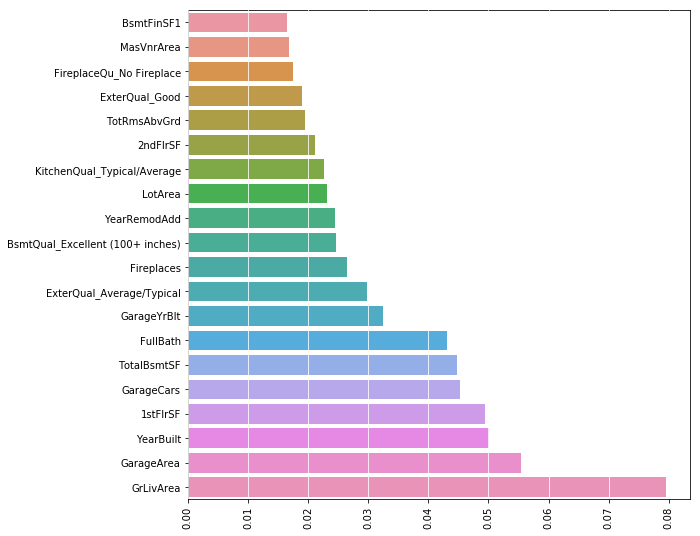

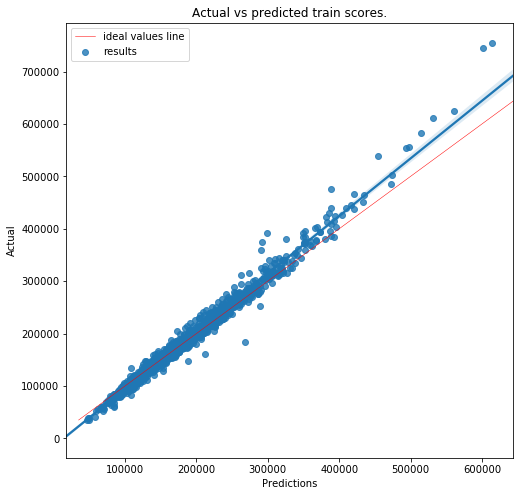

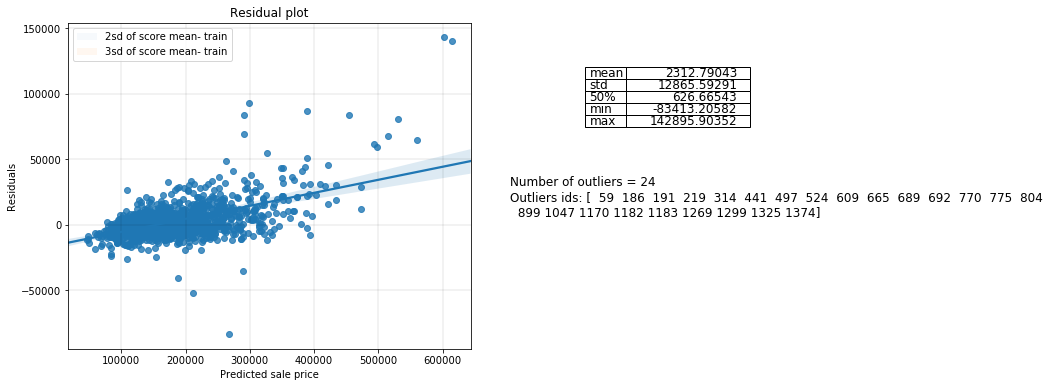

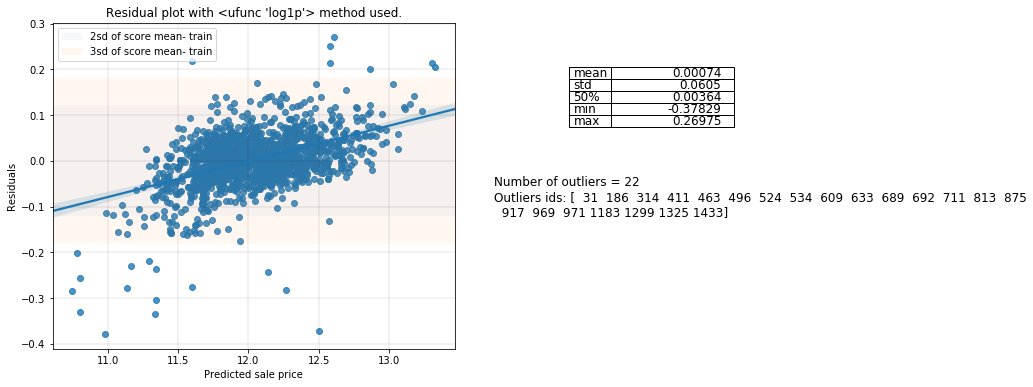

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


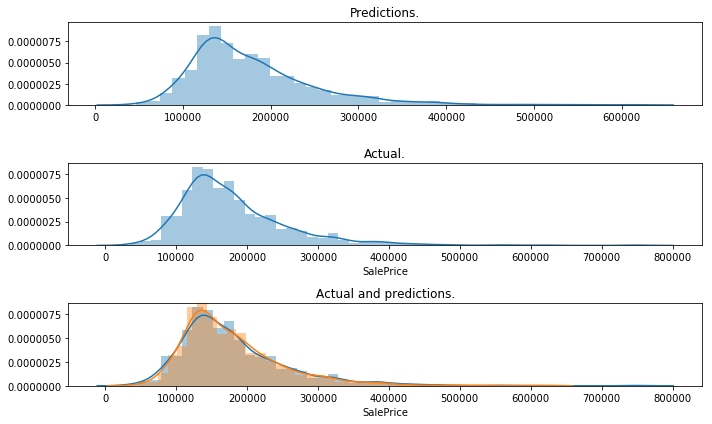

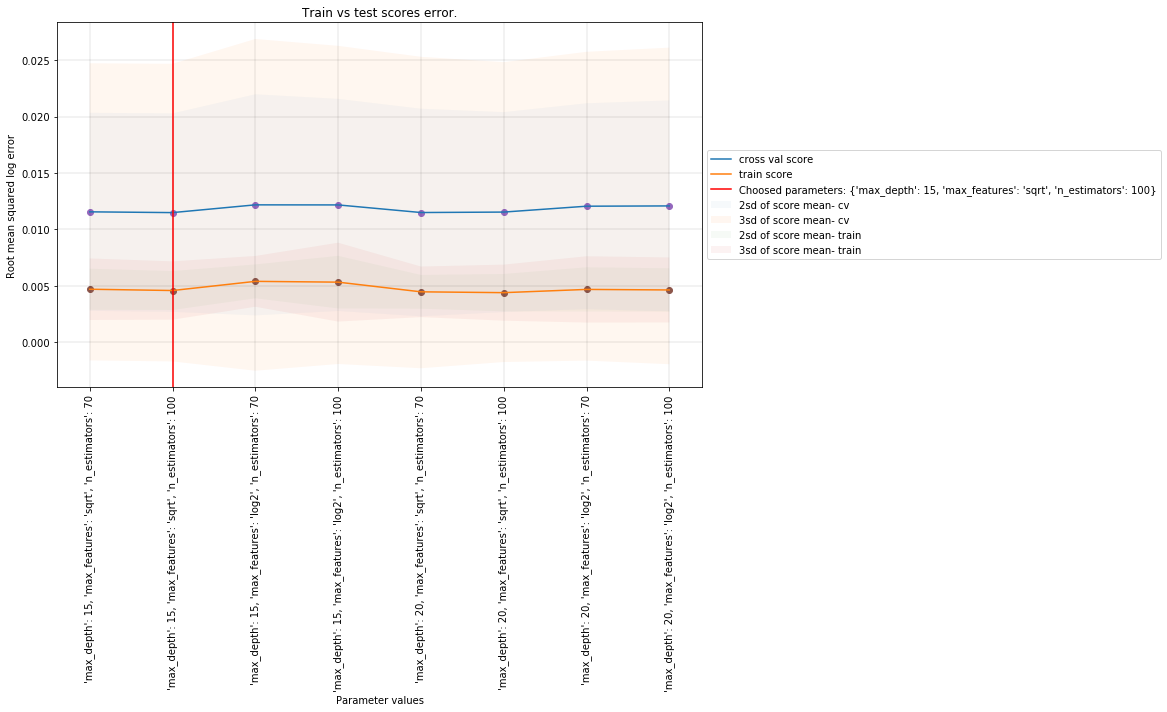

In [3]:
param_grid = {'n_estimators': [70, 100], 'max_depth': [15, 20], 'max_features': ['sqrt', 'log2']}
rf = RandomForestRegressor()
rf_results = predict(TreeResults, rf, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name='rf_tree',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

In [55]:
import matplotlib.ticker as ticker
def createQuery(best_params):
    query = ''
    for p in best_params:
        if type(best_params[p]) == str:
            query += f'({p} == \'{best_params[p]}\') and '
        else:
            query += f'({p} == {best_params[p]}) and '
    return query.replace('None', '-1')[:-5]


def plot_confidence_interval(ax, index, mean, std, dataset_type, std_count=2):
    ax.fill_between(index, mean - std_count * std, mean + std_count * std, alpha=std_count / 50,
                    label=f'{std_count}sd of score mean- {dataset_type}')


def plot_multiple_parameters_train_vs_test(grid, plot_confidence_intervals=True):
        df = pd.DataFrame(grid.cv_results_['params'])
        df.fillna(-1, inplace=True)

        query = createQuery(grid.best_params_)
        best_params_index = df.query(query).index

        checked_params = [str(cv_result).replace('{', '').replace('}', '') for cv_result in grid.cv_results_['params']]
        width_multiplier = df.shape[0] // 60 + 1
        fig, ax = plt.subplots(figsize=[width_multiplier * 10, 10], tight_layout=True)

        df['mean_train_score'] = np.sqrt(-grid.cv_results_['mean_train_score'])
        df['mean_test_score'] = np.sqrt(-grid.cv_results_['mean_test_score'])
        df['std_train_score'] = np.sqrt(grid.cv_results_['std_train_score'])
        df['std_test_score'] = np.sqrt(grid.cv_results_['std_test_score'])

        if plot_confidence_intervals:
            plot_confidence_interval(ax, df.index.values, df.mean_test_score, df.std_test_score, std_count=2, dataset_type='cv')
            plot_confidence_interval(ax, df.index.values, df.mean_test_score, df.std_test_score, std_count=3, dataset_type='cv')

            plot_confidence_interval(ax, df.index.values, df.mean_train_score, df.std_train_score, std_count=2, dataset_type='train')
            plot_confidence_interval(ax, df.index.values, df.mean_train_score, df.std_train_score, std_count=3, dataset_type='train')

        ax.scatter(x=range(len(checked_params)), y=df.mean_test_score, label=None)
        ax.plot(df.mean_test_score, label='cross val score')

        ax.scatter(x=range(len(checked_params)), y=df.mean_train_score, label=None)
        ax.plot(df.mean_train_score, label='train score')
        plt.axvline(x=best_params_index, color='r', label=f'Choosed parameters: {grid.best_params_}')

        locator = ticker.MultipleLocator()
        ax.xaxis.set_major_locator(locator)
        ax.set_xticks(np.arange(len(checked_params)))
        ax.set_xticklabels(checked_params, rotation=90)
        ax.grid(color='black', linestyle='-', linewidth=.1)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Train vs test scores error.')
        plt.xlabel('Parameter values')
        plt.ylabel('Root mean squared log error')
#         plt.yscale('log')


c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


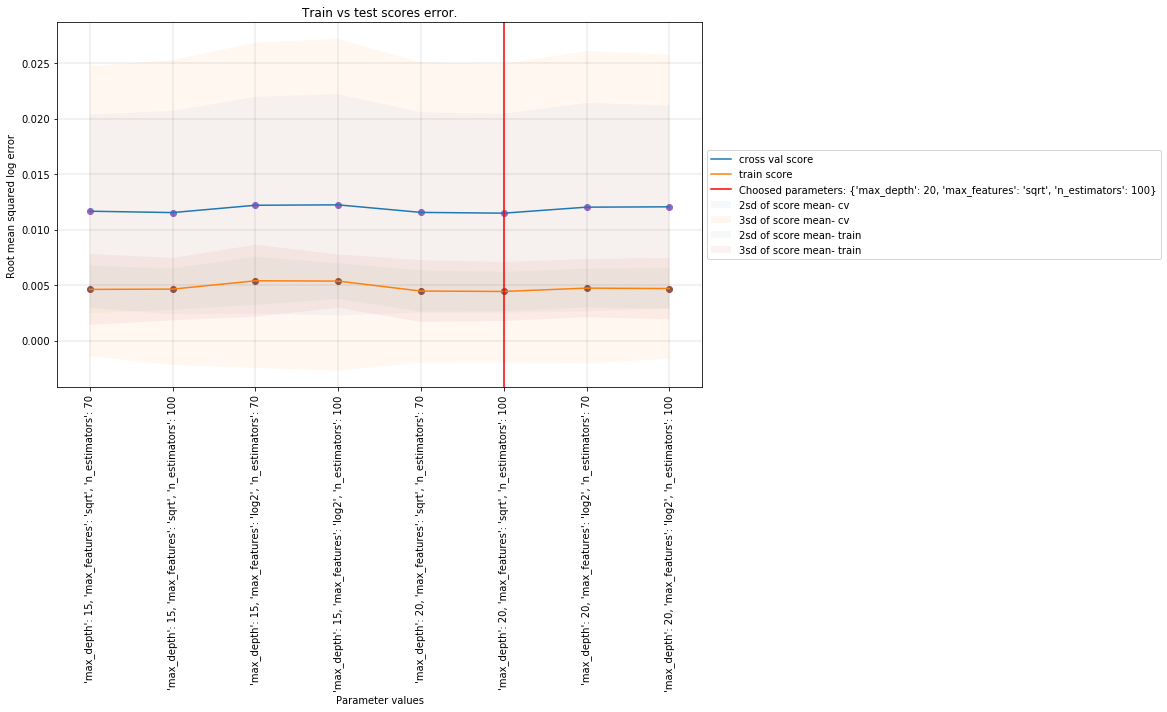

In [56]:
plot_multiple_parameters_train_vs_test(rf_results.grid)

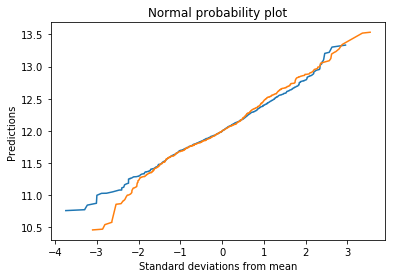

In [31]:
rf_results.train_predictions.sort()
ys=np.log1p(rf_results.train_predictions)
n = len(ys)
xs = np.random.normal(0, 1, n)
xs.sort()
plt.plot(xs, ys)

ys = np.log1p(ytrain)
ys = ys.sort_values()
n = len(ys)
xs = np.random.normal(0, 1, n)
xs.sort()
plt.plot(xs, ys)

# ideal = np.linspace(ys.min(), ys.max())
# plt.plot(ideal, ideal, c='r', linewidth=.5, label='ideal values line')


plt.xlabel('Standard deviations from mean')
plt.ylabel('Predictions')
plt.title('Normal probability plot')

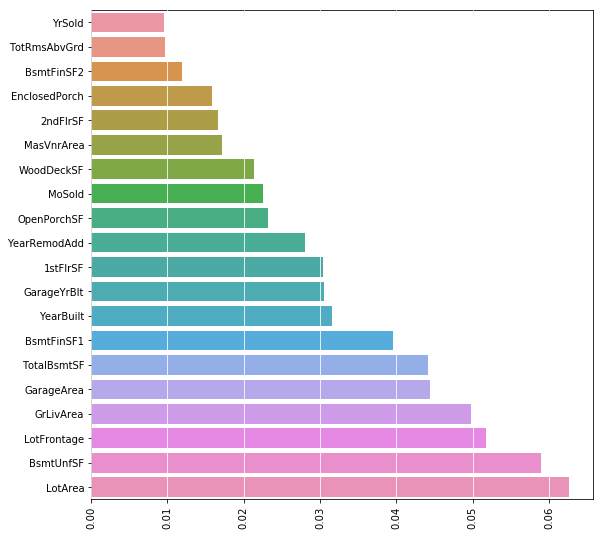

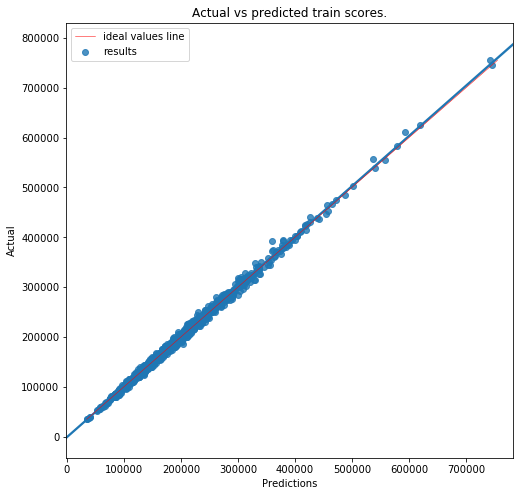

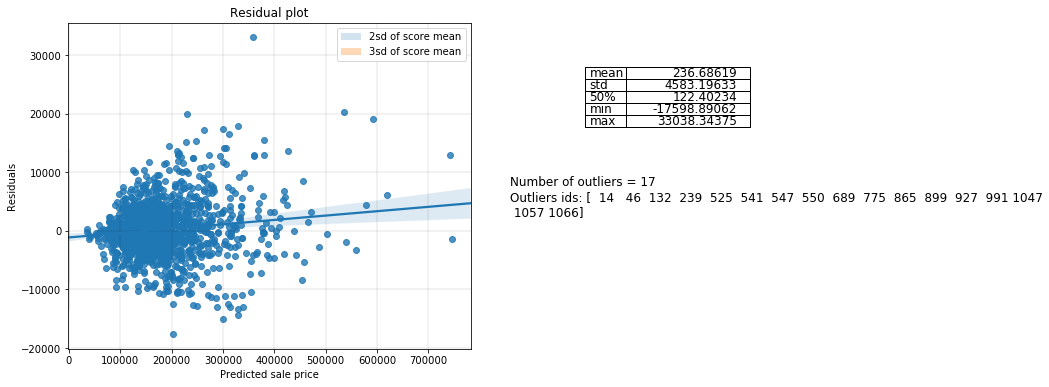

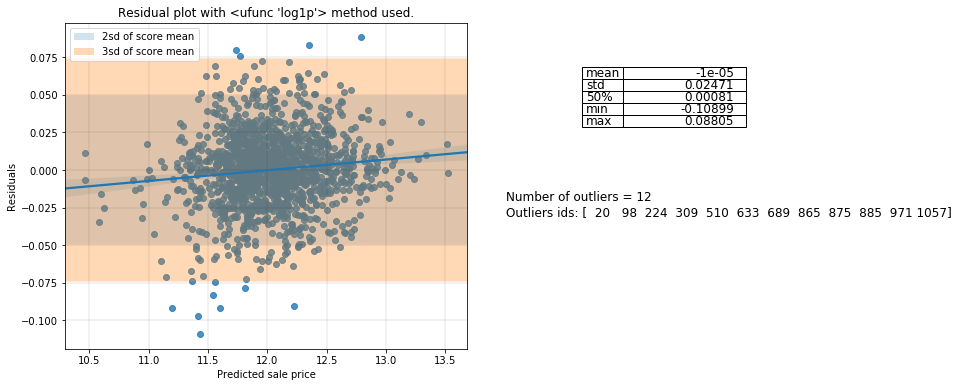

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


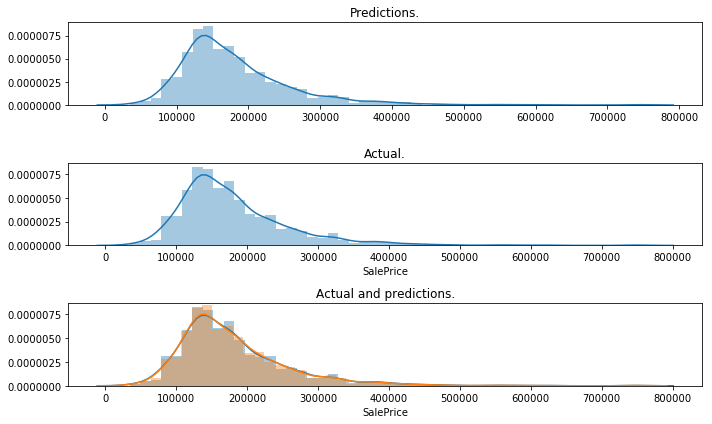

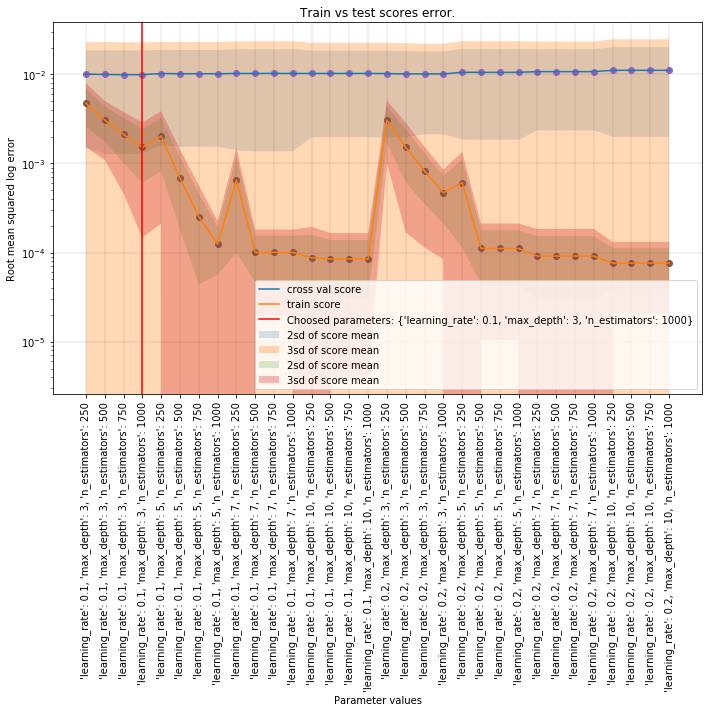

In [4]:
import xgboost as xgb

param_grid = {'learning_rate': [.1, .2,], 'n_estimators': [250, 500, 750, 1000], 'max_depth': [3, 5, 7, 10]}
xgb_model = xgb.XGBRegressor()

xgb_results = predict(TreeResults, xgb_model, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name='xgb',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

Accual vs predicted test scores and train vs test scores error plots shows overfitting problem. First plot yields almost no variation and second one high distance between train vs cross validation score. This is clearly high variance problem. Possible solutions are:
* getting more training data
* trying smaller subset of features.

When i submit this solution to kaggle i get result about .137 err rate for xgboost model which is much higher than err rate on train set, so we have high variance problem. Solutions are described above.

Getting more data is impossible, so I will try other ones.

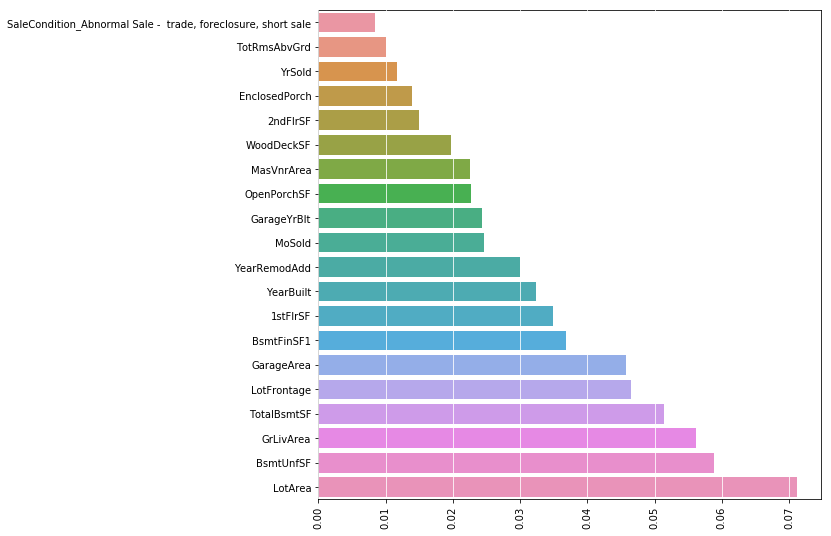

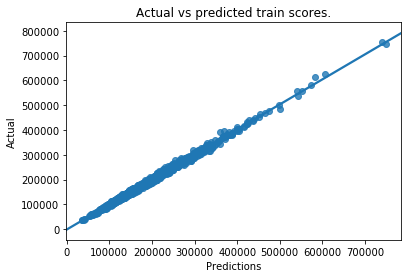

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


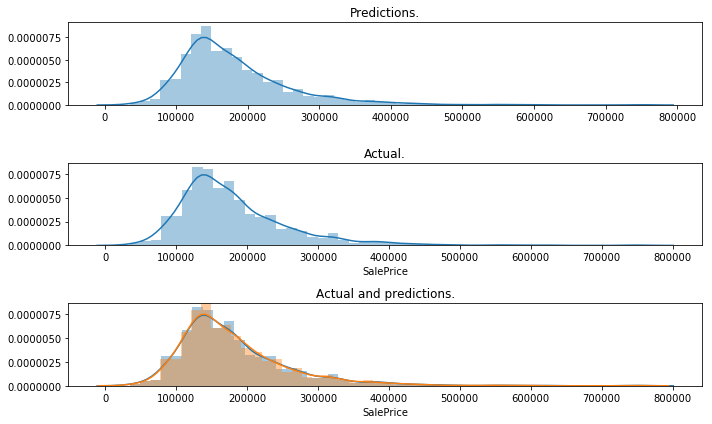

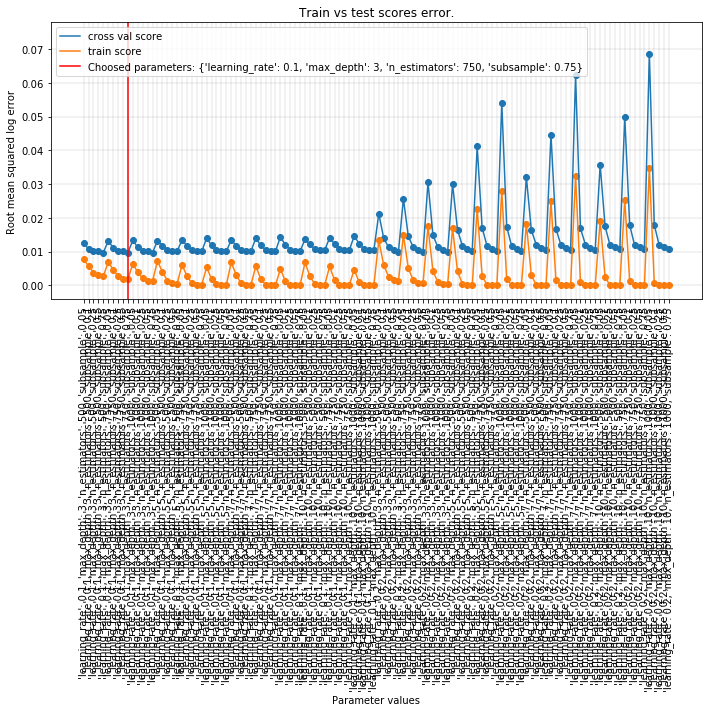

In [207]:
param_grid = {'learning_rate': [.1, .2,], 'n_estimators': [500, 750, 1000], 'max_depth': [3, 5, 7, 10], 'subsample': [.05, .1, .25, .5, .75]}
xgb_model = xgb.XGBRegressor()

xgb_subsamples_results = predict(TreeResults, xgb_model, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name='xgb',
                       predictions_form_restoring_method=restore_predictions_from_log1p)